In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  5 10:42:27 2023

@author: benp.
"""

# importing
#from IPython import get_ipython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# housekeeping
#get_ipython().magic('reset -sf')
plt.close('all')

# =============================================================================
# STEP 1
# =============================================================================

# --- TASK 1.1 ---

# getting data
riverNodes = pd.read_csv('riverNodes.csv', sep=",", decimal = ".")
distances = pd.read_csv('distances.csv', sep=",", decimal=".")
#renaming danish words
new_column_name = 'Vandmaengd'
distances = distances.rename(columns={distances.columns[12]: new_column_name})
new_column_name2 = 'Bygvaerkst'
distances = distances.rename(columns={distances.columns[7]: new_column_name2})
# removing unnecessary data
riverNodes.rename(columns={"vandfoering": "water flow (m^3/s)"}, inplace=True)
distances.rename(columns={"BI-5 (kg)": "Biological oxygen demand, 5 days (kg)"}, inplace=True)
distances = distances.drop(['Reduceret'],axis=1)
distances = distances.drop(['Udlednings'],axis=1)
distances = distances.drop(['Bygvaerkst'],axis=1)
distances = distances.drop(['Godkendels'],axis=1)
distances = distances.drop(['Ejer'],axis=1)
distances = distances.drop(['Idriftsat'],axis=1)
distances = distances.drop(['Nedlagt'],axis=1)
distances = distances.drop(['Antal over'],axis=1)

meandistm = distances.loc[:,'HubDist'].mean()*1000

# There are 27 CSO structures along the stream, located along the banks of the stream from 
# the outlet to Lyngby Lake to the Oeresund. They are located, on average, 103 m
# from the banks of the stream. 

annualCSOwaterflow = distances.loc[:,'Vandmaengd'].sum()
pollutants = distances.iloc[:,7:10].sum()
pollutants = pollutants.sum()

# 289666 m^3 of water and 12744 kg of pollutants were discharged into the stream. 
# The UF01001 CSO in Ravnholm saw the
# largest number of overflows, and the Ly R16 CSO saw the largest volume of water. 
# Ly R16 is located close to a bridge near the outlet to Lyngby Lake, while UF01001 
# is located near a highway overpass, closer to the ocean. We would thus expect the
# major negative effects to occur closer to the ocean, where pollutants have
# accumulated as they have flowed through the stream. 

meanflow = riverNodes.loc[:,'water flow (m^3/s)'].mean()
months = ['januar','februar','marts','april','maj','juni','juli','august','september','oktober','november','december']


# Convert the 'maaned' column to strings
riverNodes['maaned'] = riverNodes['maaned'].astype(str)
#looping through the month column, pulling out values for each month, 
# calculating the average, and then putting it in the empty array I made#
monthflows=pd.DataFrame(np.zeros([12,2],dtype=float),columns=['month','flow (m^3/s)'])
for i in range(len(months)):
    monthflows['month'][i] = months[i]
    idx = riverNodes['maaned'].str.contains(months[i])
    data = riverNodes[idx]
    data = data.reset_index(drop=True)
    monthflows['flow (m^3/s)'][i] = data['water flow (m^3/s)'].mean()


# The average flow of the river in Moelle Aa is 0.24 m3/s. Highest month is Jan, lowest August

# idxflowLyngby = riverNodes['beregningspunktlokalid'].str.contains('Novana_Model_MOELLEAA_DK1_3687')
# flowLyngby = riverNodes[idxflowLyngby]
# flowLyngby = flowLyngby.reset_index(drop=True)

# years = list(range(1990, 2020))
# yearsLyngby=pd.DataFrame(np.zeros([30,2],dtype=float),columns=['year','flow (m^3/s)'])
# for i in range(len(years)):
#     yearsLyngby['year'][i] = years[i]
#     idx = flowLyngby['aar'] == years[i]
#     data = flowLyngby[idx]
#     data = data.reset_index(drop=True)
#     yearsLyngby['flow (m^3/s)'][i] = data.loc[:,'water flow (m^3/s)'].sum()
#     averageannual = yearsLyngby['flow (m^3/s)'].mean()

# --- TASK 1.2 ---

# importing in annual data and selecting for the outlet from the lake
riverAnnual = pd.read_csv('yearlyvalues.csv', sep=",", decimal = ".")
riverAnnual = riverAnnual.tail(-1)
idxflowLyngby2 = riverAnnual['beregningspunktlokalid'].str.contains('Novana_Model_MOELLEAA_DK1_13500')
flowLyngby2 = riverAnnual[idxflowLyngby2]
flowLyngby2 = flowLyngby2.reset_index(drop=True)

# finding the average annual flow in m^3/s and convering to m^3/year
avgyear = flowLyngby2['vandfoering'].mean()*3600*24*365
fraction = annualCSOwaterflow/avgyear # 1.26% of the water entering the Oeresund is coming from the CSOs

# getting nitrogen data into Python for Lyngby lake
lakeData = pd.DataFrame(np.zeros([12,2],dtype=float),columns=['year','nitrogen (mg/L)'])
years = list(range(2002, 2015))
nmgL = [0.07, 0.0155, 0.02, 0.15, 0.03, 0.04, 0.173, 0.25, 0.01, 0.3, 0.15, 0.075, 0]
for i in range(len(years)):
     lakeData['year'][i] = years[i]
     lakeData['nitrogen (mg/L)'][i] = nmgL[i]

# converting the kg of nitrogen passing through the CSOs to mg/L
CSOnitromg = distances.loc[:,"Total-N (k"].sum()*1000000
CSOmgnitroperL = CSOnitromg/(annualCSOwaterflow*1000)

# looping through CSO dataset to find nitrogen contribution from each CSO
CSOnitro = pd.DataFrame(np.zeros([27,2],dtype=float),columns=['CSO','nitrogen (mg/L)'])
for i in range(len(distances)):
    CSOnitro['CSO'][i] = distances['Navn'][i]
    kgnitro = distances['Total-N (k'][i]
    mgnitro = kgnitro*1000000
    Lflow = distances['Vandmaengd'][i]*1000
    # avoid zero division
    if (Lflow == 0):
        Lflow += 1e-8
    CSOnitro['nitrogen (mg/L)'][i] = mgnitro/Lflow
meanNinlake = lakeData['nitrogen (mg/L)'].mean() # mg/L
flowfromlakeL = avgyear*1000 # L/yr
nitrofromlake = (meanNinlake*flowfromlakeL)*(1e-6) # kg/yr
nitrofromCSOs = distances['Total-N (k'].sum() # kg


# major source of nitrogen is CSOs and we know the specific ones. 

# --- TASK 1.3 ---

ibtypetal = 1.7 # in mcg/L
ibpercentile = 1.8 # in mcg/L, using median to represent most common value

# 2 units different, we will pick tomorrow (pg 61-62)

# =============================================================================
# STEP 2
# =============================================================================

3476000000

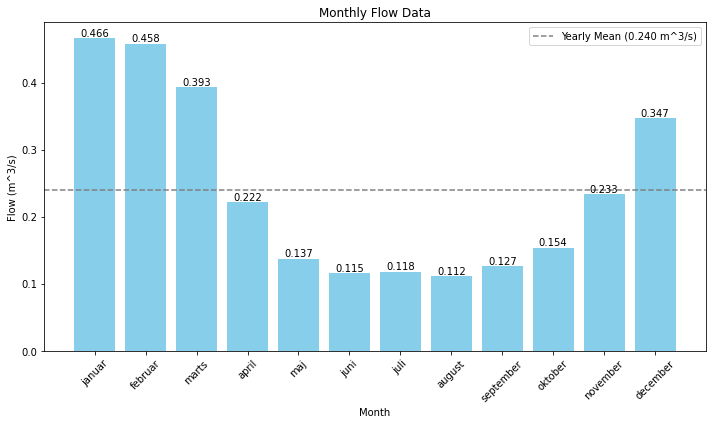

In [16]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed for your preference
plt.bar(monthflows['month'], monthflows['flow (m^3/s)'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Flow (m^3/s)')
plt.title('Monthly Flow Data')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Add labels to the bars (optional)
for i, val in enumerate(monthflows['flow (m^3/s)']):
    plt.text(i, val, f'{val:.3f}', va='bottom', ha='center')

plt.axhline(meanflow, color='grey', linestyle='--', label=f'Yearly Mean ({meanflow:.3f} m^3/s)')

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

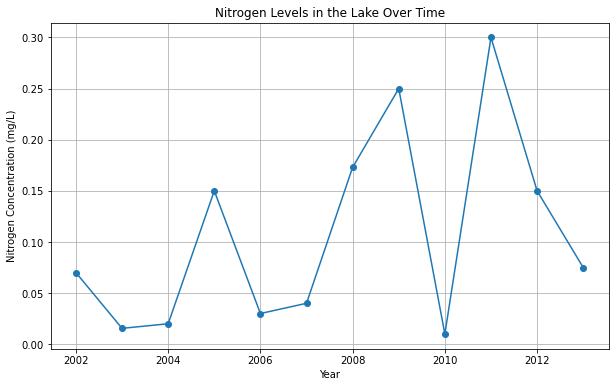

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lakeData['year'], lakeData['nitrogen (mg/L)'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Nitrogen Concentration (mg/L)')
plt.title('Nitrogen Levels in the Lake Over Time')
plt.grid(True)
plt.show()

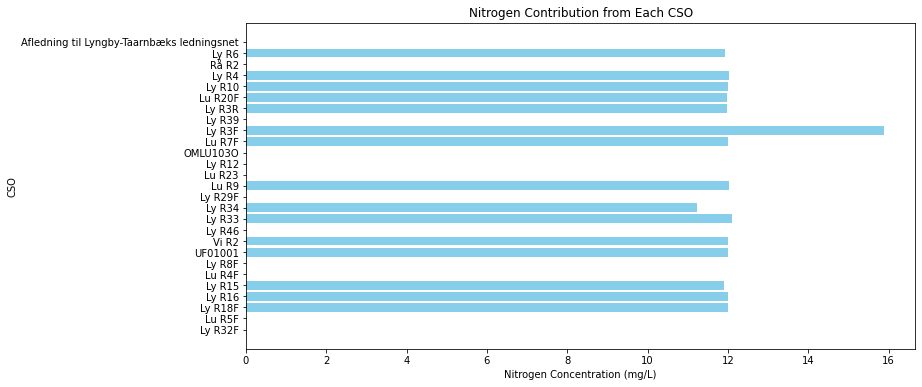

In [20]:
plt.figure(figsize=(12, 6))
plt.barh(CSOnitro['CSO'], CSOnitro['nitrogen (mg/L)'], color='skyblue')
plt.xlabel('Nitrogen Concentration (mg/L)')
plt.ylabel('CSO')
plt.title('Nitrogen Contribution from Each CSO')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

In [22]:
lake_stats = lakeData['nitrogen (mg/L)'].describe()
cso_stats = CSOnitro['nitrogen (mg/L)'].describe()

summary_table = pd.DataFrame({
    'Lake Nitrogen Stats': lake_stats,
    'CSO Nitrogen Stats': cso_stats
})

print(summary_table)

       Lake Nitrogen Stats  CSO Nitrogen Stats
count            12.000000           27.000000
mean              0.106958            6.778933
std               0.097194            6.225266
min               0.010000            0.000000
25%               0.027500            0.000000
50%               0.072500           11.898860
75%               0.155750           11.999206
max               0.300000           15.873016


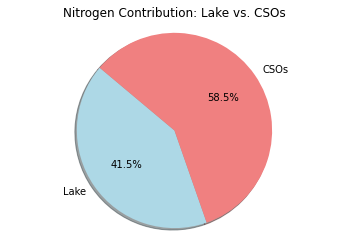

In [23]:
labels = ['Lake', 'CSOs']
sizes = [nitrofromlake, nitrofromCSOs]
colors = ['lightblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Nitrogen Contribution: Lake vs. CSOs')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()